           Member ID       Category   Amount
0     FAM001_Member1      Education   656.60
1     FAM001_Member1  Entertainment  1637.63
2     FAM001_Member1           Food   530.46
3     FAM001_Member1      Groceries   531.89
4     FAM001_Member1     Healthcare  1086.53
...              ...            ...      ...
5664  FAM200_Member6      Education   325.58
5665  FAM200_Member6  Entertainment   475.34
5666  FAM200_Member6           Food   190.30
5667  FAM200_Member6      Groceries    79.99
5668  FAM200_Member6         Travel   766.52

[5669 rows x 3 columns]


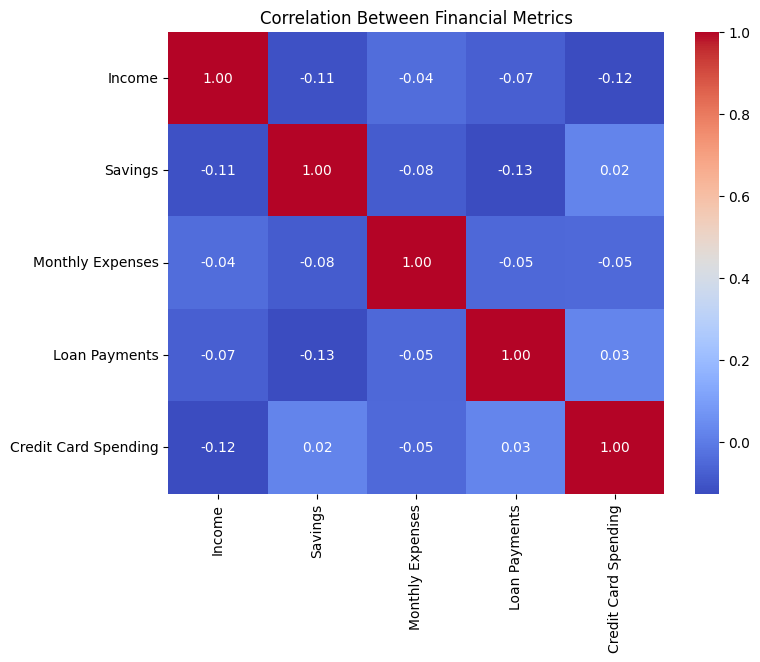

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r'C:/Users/asus/Desktop/family_financial_and_transactions_data.xlsx'
data = pd.read_excel(file_path, sheet_name='final_family_financial_and_tran')

# Analyze family-level spending patterns
family_spending = data.groupby(['Family ID', 'Category'])['Amount'].sum().reset_index()

# Analyze member-level spending patterns
member_spending = data.groupby(['Member ID', 'Category'])['Amount'].sum().reset_index()
print(member_spending)

# Correlation analysis between financial metrics
financial_metrics = data[['Income', 'Savings', 'Monthly Expenses', 'Loan Payments', 'Credit Card Spending']]
correlation_matrix = financial_metrics.corr()

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Financial Metrics")
plt.show()


In [12]:
# Define the scoring logic
def calculate_financial_score(row):
    savings_to_income = (row['Savings'] / row['Income']) * 25
    expenses_to_income = max(0, (100 - (row['Monthly Expenses'] / row['Income']) * 20))
    loan_to_income = max(0, (100 - (row['Loan Payments'] / row['Income']) * 15))
    credit_card_trend = max(0, (100 - (row['Credit Card Spending'] / row['Income']) * 15))
    goals_met = row['Financial Goals Met (%)'] * 0.1
    total_score = savings_to_income + expenses_to_income + loan_to_income + credit_card_trend + goals_met
    return min(100, total_score)

# Apply the scoring logic to each family
family_scores = data.groupby('Family ID').first().reset_index()
family_scores['Financial Score'] = family_scores.apply(calculate_financial_score, axis=1)

# Display family scores
print(family_scores[['Family ID', 'Financial Score']])


    Family ID  Financial Score
0      FAM001              100
1      FAM002              100
2      FAM003              100
3      FAM004              100
4      FAM005              100
..        ...              ...
195    FAM196              100
196    FAM197              100
197    FAM198              100
198    FAM199              100
199    FAM200              100

[200 rows x 2 columns]


C:\Users\asus\AppData\Local\Temp\ipykernel_10492\2788137344.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Amount', data=family_spending, ci=None)


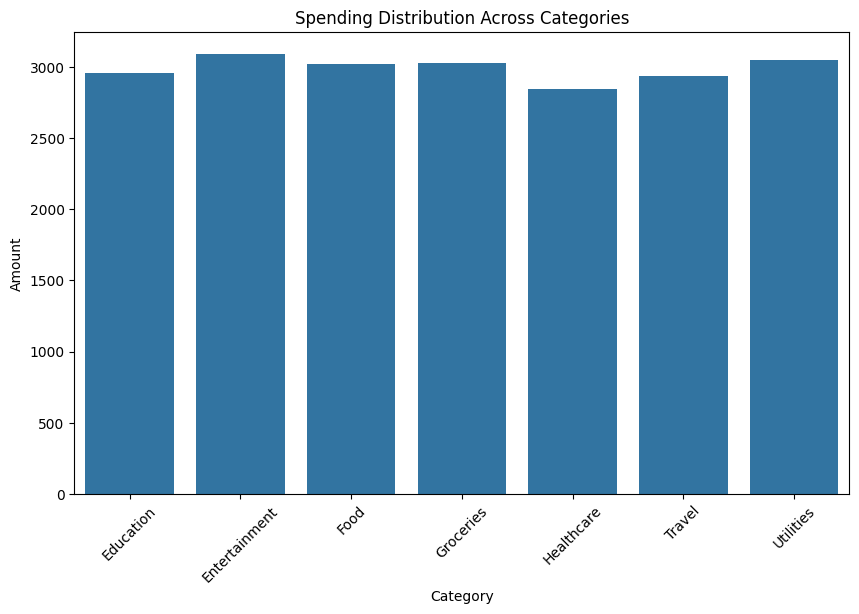

C:\Users\asus\AppData\Local\Temp\ipykernel_10492\2788137344.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Family ID', y='Financial Score', data=family_scores, ci=None)


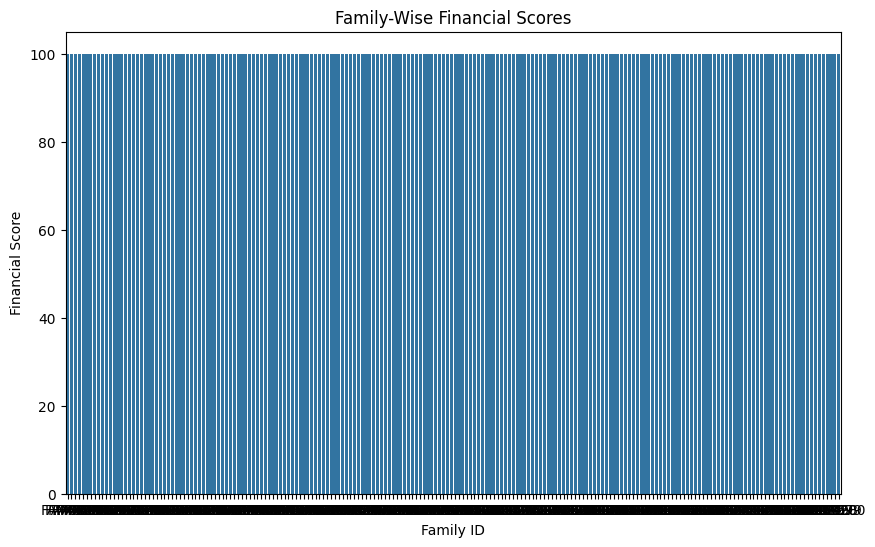

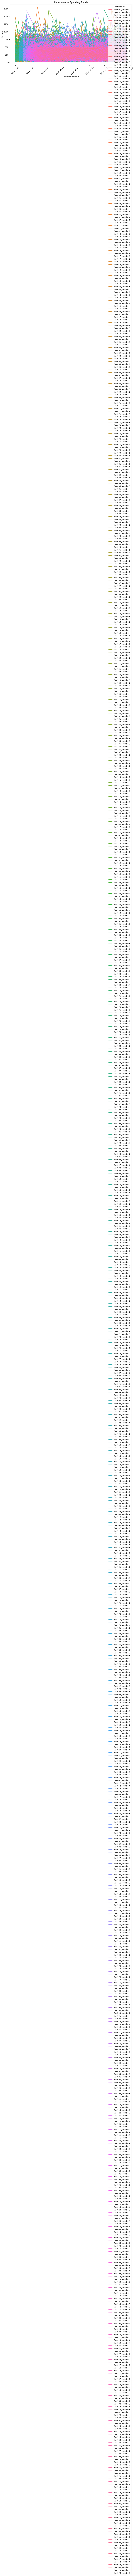

In [13]:
# Spending distribution across categories
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Amount', data=family_spending, ci=None)
plt.xticks(rotation=45)
plt.title("Spending Distribution Across Categories")
plt.show()

# Family-wise financial scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Family ID', y='Financial Score', data=family_scores, ci=None)
plt.title("Family-Wise Financial Scores")
plt.show()

# Member-wise spending trends
member_trends = data.groupby(['Transaction Date', 'Member ID'])['Amount'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='Transaction Date', y='Amount', hue='Member ID', data=member_trends)
plt.xticks(rotation=45)
plt.title("Member-Wise Spending Trends")
plt.show()


In [16]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/score', methods=['POST'])
def calculate_score():
    # Parse input data
    input_data = request.get_json()
    family_data = pd.DataFrame(input_data)
    
    # Apply scoring logic
    family_data['Financial Score'] = family_data.apply(calculate_financial_score, axis=1)
    
    # Generate insights
    insights = []
    for _, row in family_data.iterrows():
        if row['Savings'] / row['Income'] < 0.2:
            insights.append(f"Savings are below recommended levels, affecting your score by {25 - (row['Savings'] / row['Income']) * 25:.1f} points.")
    
    # Return results
    response = {
        "financial_scores": family_data[['Family ID', 'Financial Score']].to_dict(orient='records'),
        "insights": insights
    }
    return jsonify(response)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


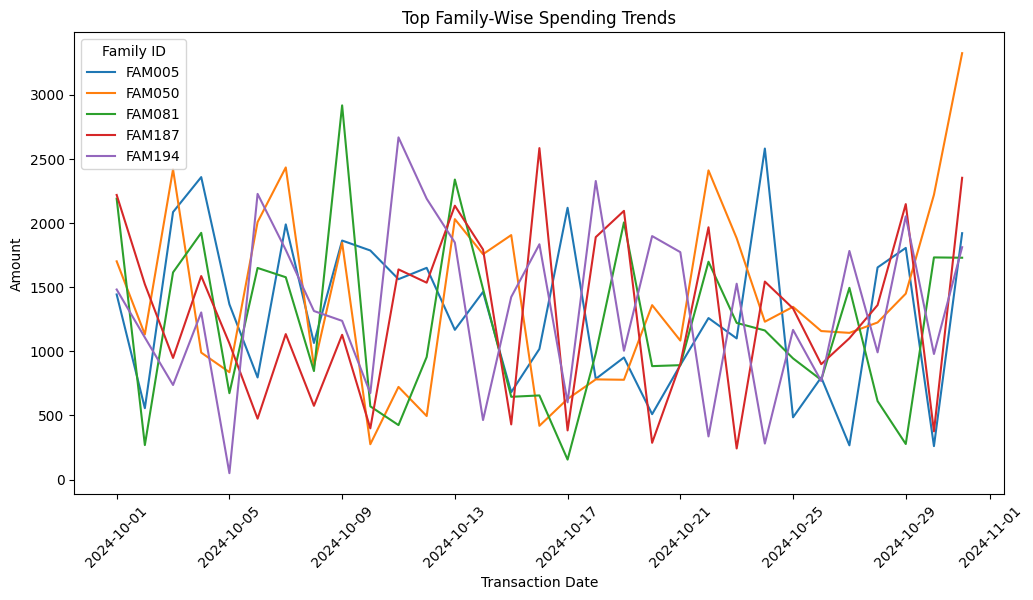

In [18]:
# Calculate total spending per family
family_total_spending = data.groupby('Family ID')['Amount'].sum().reset_index()

# Sort families by total spending in descending order and pick top N families (e.g., top 5 families)
top_families = family_total_spending.sort_values('Amount', ascending=False).head(5)['Family ID']

# Filter the data to include only the top families
top_family_trends = data[data['Family ID'].isin(top_families)]

# Group by Transaction Date and Family ID
family_trends = top_family_trends.groupby(['Transaction Date', 'Family ID'])['Amount'].sum().reset_index()

# Plot family-wise spending trends for top families
plt.figure(figsize=(12, 6))
sns.lineplot(x='Transaction Date', y='Amount', hue='Family ID', data=family_trends)
plt.xticks(rotation=45)
plt.title("Top Family-Wise Spending Trends")
plt.show()


TypeError: Invalid object type at position 0

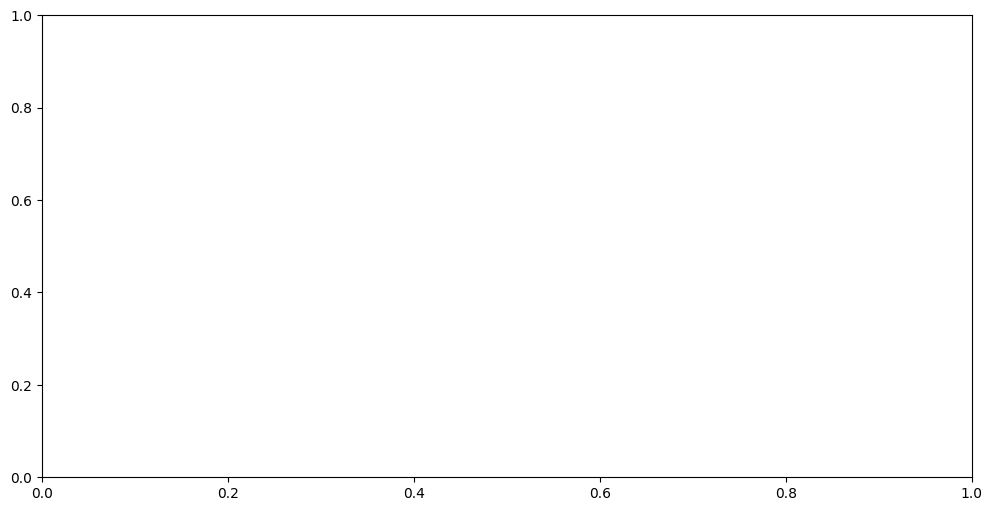

In [19]:
# Ensure that 'Transaction Date' is in datetime format
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])

# Create a new column for the month and year
data['Month'] = data['Transaction Date'].dt.to_period('M')

# Group by Month and Family ID
monthly_family_trends = data.groupby(['Month', 'Family ID'])['Amount'].sum().reset_index()

# Plot monthly family-wise spending trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Amount', hue='Family ID', data=monthly_family_trends)
plt.xticks(rotation=45)
plt.title("Monthly Family-Wise Spending Trends")
plt.show()
